In [3]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

2022-11-05 14:42:13.841043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 14:42:13.842557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 14:42:13.843003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 14:42:13.843383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 14:42:13.843498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

True

In [5]:
baseDir = './Data'
highResDir = os.path.join(baseDir , 'high_res/')
lowResDir = os.path.join(baseDir, 'low_res/')

In [6]:
data = pd.read_csv(os.path.join(baseDir, 'image_data.csv'))
data['high_res'] = data['high_res'].apply(
    lambda x: os.path.join(highResDir, x))
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowResDir, x))


In [15]:
batchSize = 2
imageDataGenerator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [16]:
trainHighResGenerator = imageDataGenerator.flow_from_dataframe(
    data,
    x_col='high_res',
    target_size=(800, 1200),
    class_mode=None,
    batch_size=batchSize,
    seed=42,
    subset='training'
)

trainLowResGenerator = imageDataGenerator.flow_from_dataframe(
    data, x_col='low_res', target_size=(800, 1200), class_mode=None, batch_size=batchSize, seed=42, subset='training')

valHighResGenerator = imageDataGenerator.flow_from_dataframe(
    data, x_col='high_res', target_size=(800, 1200), class_mode=None, batch_size=batchSize, seed=42, subset='validation')
valLowResGenerator = imageDataGenerator.flow_from_dataframe(
    data, x_col='low_res', target_size=(800, 1200), class_mode=None, batch_size=batchSize, seed=42, subset='validation')

Found 3010 validated image filenames.
Found 3010 validated image filenames.
Found 752 validated image filenames.
Found 752 validated image filenames.


In [17]:
trainGenerator = zip(trainLowResGenerator, trainHighResGenerator)
valGenerator = zip(valLowResGenerator, valHighResGenerator)
def imageGenerator(generator):
    for lowRes, highRes in generator:
        yield lowRes, highRes

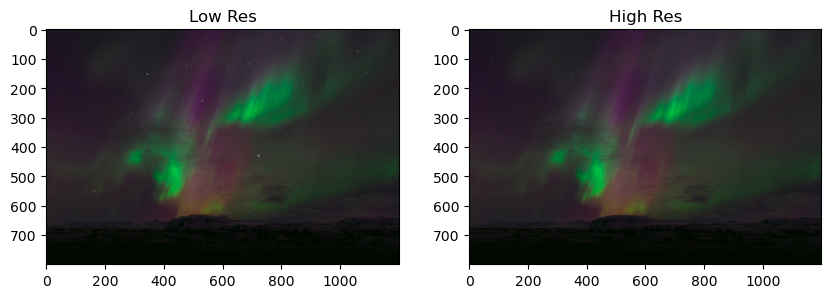

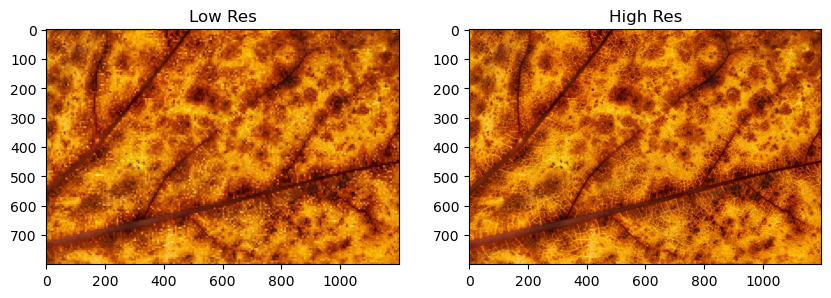

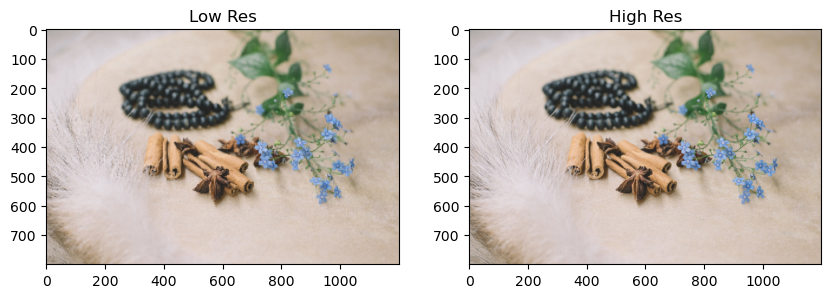

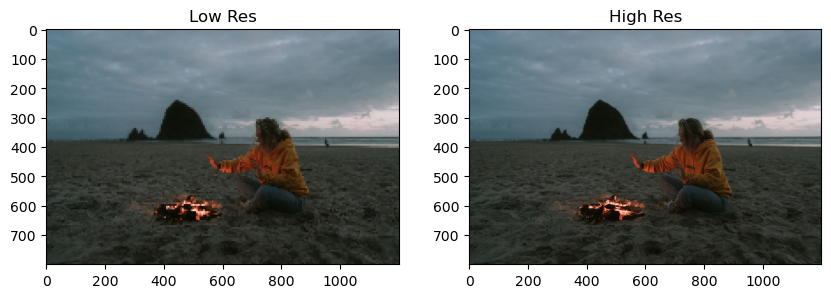

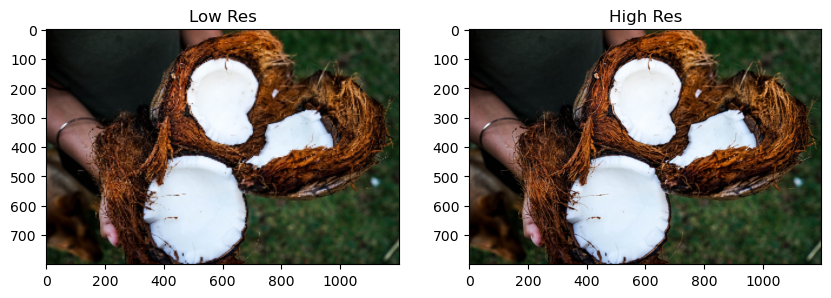

In [18]:
n = 0
for i, m in trainGenerator:
    img, out = i, m
    if n < 5:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img[0])
        axes[0].set_title('Low Res')
        axes[1].imshow(out[0])
        axes[1].set_title('High Res')
        plt.show()
        n += 1
    else:
        break

In [19]:
inputImg = Input(shape=(800, 1200, 3))
l1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputImg)
l2 = Conv2D(64, (3, 3), activation='relu', padding='same')(l1)
l3 = MaxPooling2D((2, 2), padding='same')(l2)
l3 = Dropout(0.2)(l3)
l4 = Conv2D(128, (3, 3), activation='relu', padding='same')(l3)
l5 = Conv2D(128, (3, 3), activation='relu', padding='same')(l4)
l6 = MaxPooling2D((2, 2), padding='same')(l5)
l7 = Conv2D(256, (3, 3), activation='relu', padding='same')(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), activation='relu', padding='same')(l8)
l10 = Conv2D(128, (3, 3), activation='relu', padding='same')(l9)

l11 = add([l10, l5])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), activation='relu', padding='same')(l12)
l14 = Conv2D(64, (3, 3), activation='relu', padding='same')(l13)

l15 = add([l14, l2])
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l15)

autoEncoder = Model(inputImg, decoded)
autoEncoder.compile(optimizer='adam', loss='mse')

In [20]:
trainSamples = trainHighResGenerator.samples
valSamples = valHighResGenerator.samples

trainImageGenerator = imageGenerator(trainGenerator)
valImageGenerator = imageGenerator(valGenerator)

In [26]:
modelPath = './model.h5'
checkpoint = ModelCheckpoint(modelPath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=9, mode='min', verbose=1, restore_best_weights=True)
learningRateReduction = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.2, min_lr=0.0000001)

In [27]:
hist = autoEncoder.fit(
    trainImageGenerator,
    steps_per_epoch=trainSamples//batchSize,
    validation_data=valImageGenerator,
    validation_steps=valSamples//batchSize,
    epochs=100,
    callbacks = [checkpoint, earlyStop, learningRateReduction]
)

Epoch 1/100
1505/1505 [==============================] - ETA: 0s - loss: 0.0023
Epoch 1: val_loss improved from inf to 0.00071, saving model to ./model.h5
1505/1505 [==============================] - 469s 312ms/step - loss: 0.0023 - val_loss: 7.1276e-04 - lr: 1.0000e-05
Epoch 2/100
1505/1505 [==============================] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss did not improve from 0.00071
1505/1505 [==============================] - 475s 315ms/step - loss: 0.0023 - val_loss: 7.8229e-04 - lr: 1.0000e-05
Epoch 3/100
1505/1505 [==============================] - ETA: 0s - loss: 0.0023
Epoch 3: val_loss did not improve from 0.00071
1505/1505 [==============================] - 473s 315ms/step - loss: 0.0023 - val_loss: 7.2437e-04 - lr: 1.0000e-05
Epoch 4/100
1505/1505 [==============================] - ETA: 0s - loss: 0.0023
Epoch 4: val_loss did not improve from 0.00071
1505/1505 [==============================] - 449s 299ms/step - loss: 0.0023 - val_loss: 7.5974e-04 - lr: 1.0000e-05
